## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [36]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

## Загружаем исходные данные

In [3]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [9]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [10]:
train_vec = train[:, 1:]
train_vec.shape

(42000, 784)

In [11]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

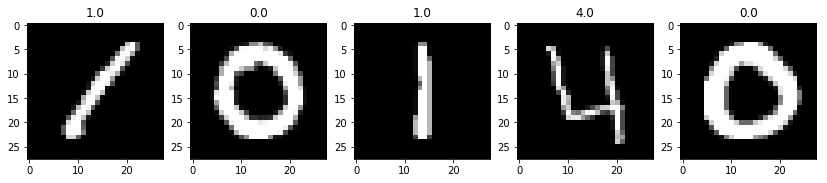

In [38]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [90]:
def hist(img):
    # Вычисляем X и Y составляющие градиента с помощью оператора Собеля
    sobel_x = np.zeros_like(img) 
    sobel_y = np.zeros_like(img) 
    for i in range(len(img)):
        sobel_x[i] = cv2.Sobel(img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
        sobel_y[i] = cv2.Sobel(img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
        
    #Вычисляем X и Y составляющие градиента с помощью оператора Собеля
    grad, theta = cv2.cartToPolar(sobel_x, sobel_y)    
    # Вычисляем гистограммы градиентов    
    hist = np.zeros((len(img), 16))
    for i in range(len(img)):
        h, borders = np.histogram(theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=grad[i])
        hist[i] = h 
    
    # Нормируем вектор гистограммы
    hist = hist / np.linalg.norm(hist, axis=1)[:, None]    
        
    return hist

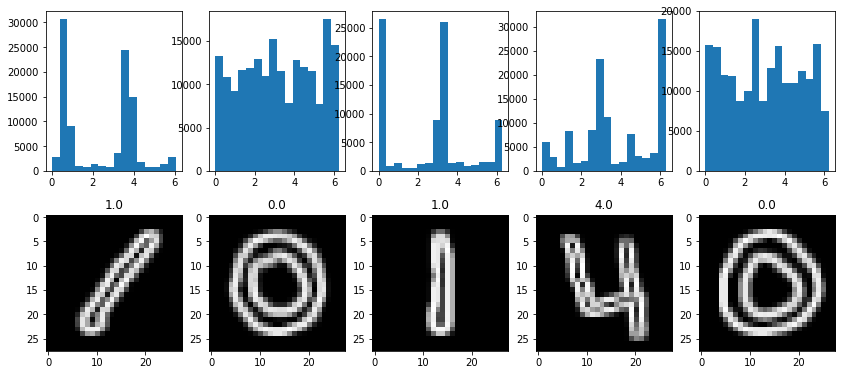

In [97]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограмы

(42000, 16)

In [91]:
train_hist = hist(train_img)
test_hist = hist(test_img)

In [93]:
from sklearn.model_selection import train_test_split
y_train_hist, y_val_hist, x_train_hist, x_val_hist = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [94]:
knn = KNeighborsClassifier(leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2)
knn.fit( x_train_hist, y_train_hist )

KNeighborsClassifier(algorithm='auto', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [95]:
pred_val_hist = knn.predict(x_val_hist)

In [96]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val_hist, pred_val_hist))

Accuracy: 0.5813095238095238


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_val_hist, pred_val_hist))

             precision    recall  f1-score   support

        0.0       0.31      0.46      0.37       816
        1.0       0.95      0.95      0.95       909
        2.0       0.39      0.39      0.39       846
        3.0       0.60      0.65      0.62       937
        4.0       0.66      0.67      0.66       839
        5.0       0.64      0.57      0.60       702
        6.0       0.38      0.35      0.36       785
        7.0       0.84      0.71      0.77       893
        8.0       0.49      0.42      0.45       835
        9.0       0.64      0.58      0.61       838

avg / total       0.60      0.58      0.59      8400



In [60]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val_hist, pred_val_hist))

[[377   5  76  40  28  10 130   4 115  31]
 [ 12 864   1   0  18   0   2   3   1   8]
 [116   0 329 150  12  89  51  11  75  13]
 [ 53   0 129 606   1  68  17   1  59   3]
 [ 47  26   8   2 560   0  70  35  10  81]
 [ 24   0 112 120   1 398   8   7  28   4]
 [233   5  58  17  76   9 274  15  48  50]
 [ 26   9  34   3  84  16  27 638   5  51]
 [231   0  58  60   7  29  66   6 348  30]
 [ 89   5  37   9  62   6  79  44  18 489]]


In [61]:
pred_val_hist = knn.predict_proba(x_val_hist)

In [63]:
pred_val_hist.shape

(8400, 10)

## PCA

In [27]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=40)
for X_batch in np.array_split(train_vec, n_batches):
    inc_pca.partial_fit(X_batch)
X_mnist_reduced = inc_pca.transform(train_vec)
X_mnist_reduced.shape

(42000, 40)

In [28]:
X_mnist_reduced_test = inc_pca.transform(test)
X_mnist_reduced_test.shape

(28000, 40)

## Разбиваем выборку на обучение и валидацию

In [29]:
from sklearn.model_selection import train_test_split
y_train_pca, y_val_pca, x_train_pca, x_val_pca = train_test_split(
    train_label, X_mnist_reduced, test_size=0.2,
    random_state=42)

## Предсказываем

In [30]:
knn = KNeighborsClassifier(leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2)
knn.fit( x_train_pca, y_train_pca )

KNeighborsClassifier(algorithm='auto', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [31]:
pred_val_pca = knn.predict(x_val_pca)

## Оцениваем качество решение на валидационной выборке

In [32]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val_pca, pred_val_pca))

Accuracy: 0.9732142857142857


In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_val_pca, pred_val_pca))

             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99       816
        1.0       0.97      1.00      0.98       909
        2.0       0.98      0.97      0.98       846
        3.0       0.97      0.96      0.97       937
        4.0       0.99      0.96      0.98       839
        5.0       0.96      0.96      0.96       702
        6.0       0.97      0.99      0.98       785
        7.0       0.97      0.97      0.97       893
        8.0       0.98      0.96      0.97       835
        9.0       0.95      0.96      0.96       838

avg / total       0.97      0.97      0.97      8400



In [57]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val_pca, pred_val_pca))

[[812   0   1   0   0   0   3   0   0   0]
 [  0 907   0   0   0   0   2   0   0   0]
 [  5   6 821   2   1   0   1   9   1   0]
 [  2   2   4 899   0  12   0   5   8   5]
 [  1   3   0   0 809   0   4   3   0  19]
 [  0   1   1   9   0 677   8   0   2   4]
 [  5   0   0   0   0   2 776   0   2   0]
 [  0  12   3   2   2   0   0 864   0  10]
 [  1   2   3   6   2   9   4   1 805   2]
 [  2   2   2   8   5   4   0   9   1 805]]


## Предсказания на тестовыйх данных

In [35]:
pred_test = knn.predict(X_mnist_reduced_test)

## Визуализируем предсказания

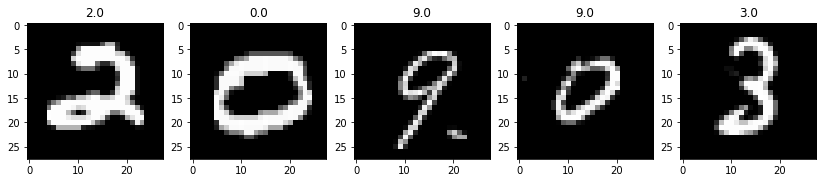

In [259]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [260]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [261]:
!head submit.txt

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


In [163]:
# submission scored 0.96771 n154
# 0.96814 n = 100
#0.97028 n = 50
#